In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.linalg import eigvals
import random

In [2]:
def matrix_power(matrix, power):
    """
    Calculates the power of a matrix.

    Parameters:
    matrix (numpy.ndarray): The matrix to calculate the power of.
    power (int): The power to raise the matrix to.

    Returns:
    numpy.ndarray: The resulting matrix.
    """
    return np.linalg.matrix_power(matrix, power)

def matrix_vector_multiplication(matrix, vector):
    """
    Calculates the multiplication of a matrix and a vector.

    Parameters:
    matrix (numpy.ndarray): The matrix to multiply.
    vector (numpy.ndarray): The vector to multiply.

    Returns:
    numpy.ndarray: The resulting vector.
    """
    return np.dot(matrix, vector)

def plot_graph(G):
    pos = nx.circular_layout(G)  # Position nodes in a circle
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, 
            edge_color='k', linewidths=1, font_size=15, 
            arrows=True, arrowsize=20)
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

def create_weighted_directed_cycle_graph(N):
    """
    Create a weighted directed cycle graph with N nodes.

    Parameters:
    - N: int, the number of nodes in the graph.

    Returns:
    - nx.DiGraph: The weighted directed cycle graph.
    """
    graph = nx.DiGraph()
    nodes = list(range(N))
    graph.add_nodes_from(nodes)

    for i in range(N):
        weight = random.uniform(-1, 1)
        graph.add_edge(i, (i + 1) % N, weight=weight)

    # return the adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    return adj_matrix

In [58]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers


def iterated_best_responses(G, q, tolerance=1e-5, max_iterations=1000):
    N = G.shape[0]  # Number of players
    efforts = np.random.rand(N)  # Initialize efforts with random values
    q_inv = np.linalg.inv(np.eye(N) + G) @ q  # Precompute (I+G)^-1 q for efficiency (or (I+G+G^2+...+G^N)^-1 q)
    
    for iteration in range(max_iterations):
        efforts_new = np.zeros(N)
        
        for i in range(N):
            # Calculate the best response for player i
            # Assuming all other players are exerting effort, for simplicity
            effort_i = q_inv[i]
            
            # Decide whether to exert effort or free-ride
            if effort_i > 0:
                efforts_new[i] = effort_i
            else:
                efforts_new[i] = 0  # Free-riding
        
        # Check for convergence
        if np.linalg.norm(efforts - efforts_new, np.inf) < tolerance:
            # print(f"Equilibrium found after {iteration + 1} iterations.")
            return efforts_new
        
        efforts = efforts_new  # Update efforts for the next iteration
    
    # print("Max iterations reached without convergence.")
    return efforts

# Example usage
N = 3  # Number of players
G = np.array([[0, -0.4, 0], [0, 0, 0.2], [0.6, 0, 0]])  # Example G matrix
q = np.array([1, 1, 1])  # Example q vector

efforts = iterated_best_responses(G, q)
print("Efforts at Equilibrium:", efforts)


Efforts at Equilibrium: [1.38655462 0.96638655 0.16806723]


In [59]:
def create_weighted_watts_strogatz(N, k, p, weight_range=(-1, 1)):
    """
    Create a weighted Watts-Strogatz small-world network.

    Parameters:
    - N (int): Number of nodes in the graph.
    - k (int): Each node is connected to k nearest neighbors in ring topology.
    - p (float): The probability of rewiring each edge.
    - weight_range (tuple): The range (min, max) of the weights to assign to the edges.

    Returns:
    - G (networkx.Graph): A weighted Watts-Strogatz small-world network.
    """
    # Generate an unweighted Watts-Strogatz small-world graph
    G = nx.watts_strogatz_graph(N, k, p)
    
    # Assign random weights to each edge within the specified range
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(*weight_range)

    # adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    return adj_matrix

In [71]:
max_hops = 20
n = 10
q = np.ones(n)
# q = np.random.rand(n)
# print(q)

# G = np.array([[0, -0.4, 0], [0, 0, 0.2], [0.6, 0, 0]])

# 4x4 cycle graph
# G = np.array([[0, 0.5, 0, 0.5], [0.5, 0, 0.5, 0], [0, 0.5, 0, 0.5], [0.5, 0, 0.5, 0]])

G1 = create_weighted_directed_cycle_graph(n)
G2 = create_weighted_watts_strogatz(n, 2, 0.1)


# generate a weighted erdos renyi graph using networkx
G = nx.erdos_renyi_graph(n, 0.5, directed=True)
for (u, v) in G.edges():
    G[u][v]['weight'] = (np.random.rand()-0.5) * 2 # random weight between -1 and 1
G3 = nx.to_numpy_array(G)
G4 = (np.random.rand(n, n)-0.5)*2


# np.fill_diagonal(G, 0)

In [72]:
x_star_list_1 = []
x_star_list_2 = []
x_star_list_3 = []
x_star_list_4 = []


for hop in range(1, max_hops):
    A1 = sum_of_powers(G1, hop)
    x_star = iterated_best_responses(A1, q)
    x_star_list_1.append(x_star)

for hop in range(1, max_hops):
    A2 = sum_of_powers(G2, hop)
    x_star = iterated_best_responses(A2, q)
    x_star_list_2.append(x_star)

for hop in range(1, max_hops):
    A3 = sum_of_powers(G3, hop)
    x_star = iterated_best_responses(A3, q)
    x_star_list_3.append(x_star)

for hop in range(1, max_hops):
    A4 = sum_of_powers(G4, hop)
    x_star = iterated_best_responses(A4, q)
    x_star_list_4.append(x_star)

# print the results
# for hop, x_star in enumerate(x_star_list):
#     print(f"Solution for {hop+1} hops: {x_star}")

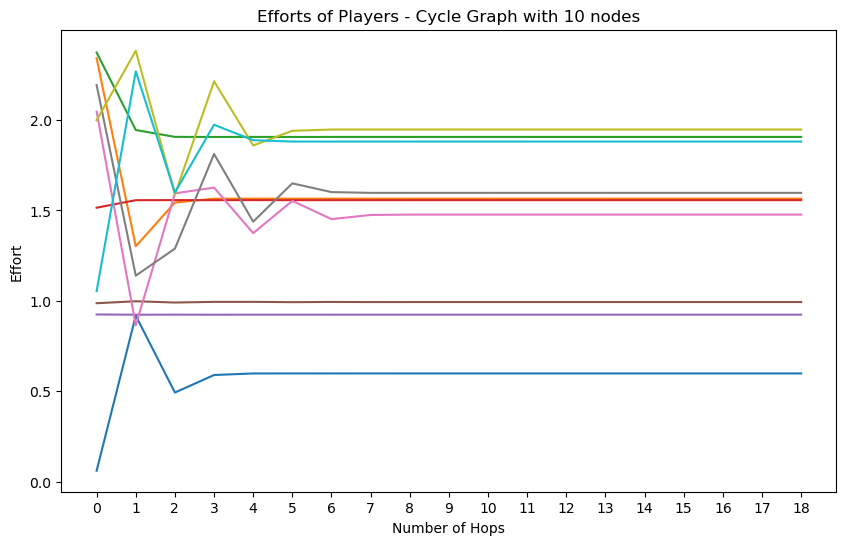

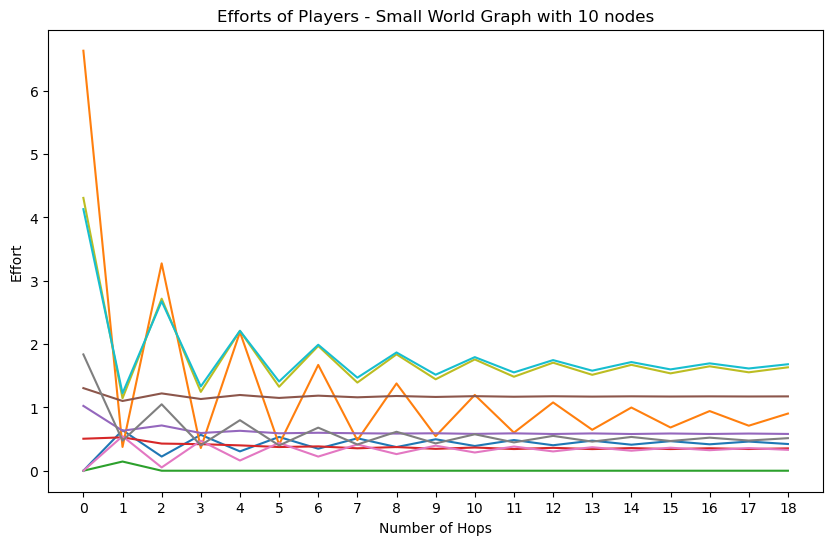

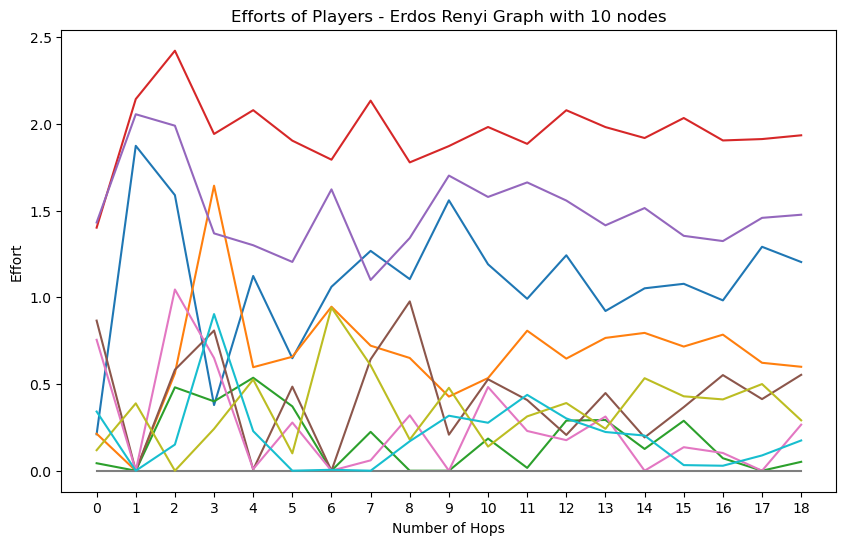

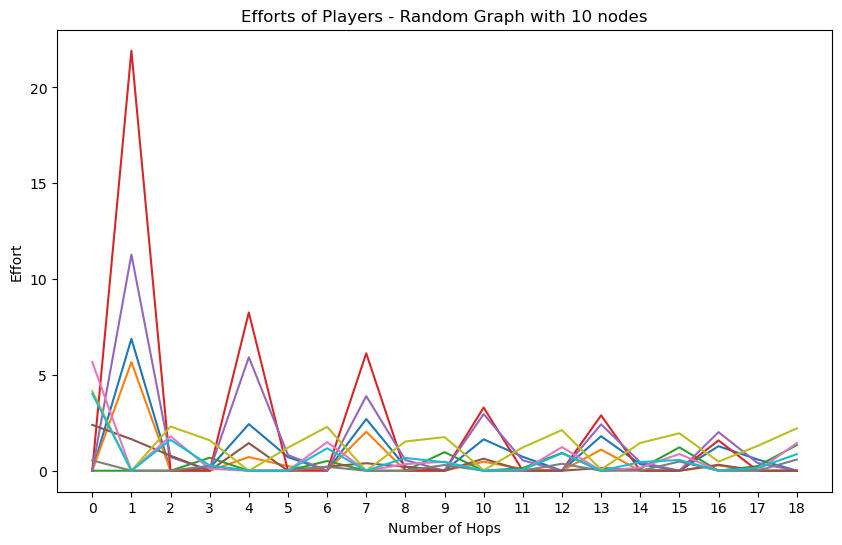

In [73]:
# plot the efforts of each player over time
plt.figure(figsize=(10, 6))
for player in range(n):
    plt.plot([x_star[player] for x_star in x_star_list_1], label=f"Player {player}")
plt.xlabel("Number of Hops")
plt.xticks(range(max_hops-1))
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Cycle Graph with {n} nodes")
# plt.legend(prop = {'size': 7}, loc='upper right')
plt.show()

# plot_graph(nx.from_numpy_matrix(G, create_using=nx.DiGraph()))


# plot the efforts of each player over time
plt.figure(figsize=(10, 6))
for player in range(n):
    plt.plot([x_star[player] for x_star in x_star_list_2], label=f"Player {player}")
plt.xlabel("Number of Hops")
plt.xticks(range(max_hops-1))
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Small World Graph with {n} nodes")
# plt.legend(prop = {'size': 7}, loc='upper right')
plt.show()

# plot the efforts of each player over time
plt.figure(figsize=(10, 6))
for player in range(n):
    plt.plot([x_star[player] for x_star in x_star_list_3], label=f"Player {player}")
plt.xlabel("Number of Hops")
plt.xticks(range(max_hops-1))
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Erdos Renyi Graph with {n} nodes")
# plt.legend(prop = {'size': 7}, loc='upper right')
plt.show()

# plot the efforts of each player over time
plt.figure(figsize=(10, 6))
for player in range(n):
    plt.plot([x_star[player] for x_star in x_star_list_4], label=f"Player {player}")
plt.xlabel("Number of Hops")
plt.xticks(range(max_hops-1))
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Random Graph with {n} nodes")
# plt.legend(prop = {'size': 7}, loc='upper right')
plt.show()


# plot_graph(nx.from_numpy_matrix(G, create_using=nx.DiGraph()))

In [66]:
# def calculate_best_response(q, G, n_players):
#     """
#     Calculate the best response for each player based on the current effort levels.
#     """
#     I = np.eye(n_players)  # Identity matrix
#     try:
#         inverse_matrix = np.linalg.inv(I + G)
#         best_responses = np.maximum(0, inverse_matrix @ q)  # Calculate best response for each player
#     except np.linalg.LinAlgError:
#         # In case (I + G) is singular, we cannot compute its inverse directly
#         best_responses = np.zeros(n_players)
#     return best_responses

# def iterated_best_response(q, G, tolerance=1e-6, max_iterations=1000):
#     """
#     Iteratively calculate the best response for each player until convergence.
#     """
#     n_players = len(q)
#     efforts = np.zeros(n_players)  # Initial guess: all players are free-riding

#     for iteration in range(max_iterations):
#         new_efforts = calculate_best_response(q, G, n_players)

#         # Check for convergence
#         if np.max(np.abs(new_efforts - efforts)) < tolerance:
#             print(f"Converged after {iteration} iterations.")
#             return new_efforts
        
#         # Update efforts for the next iteration
#         efforts = new_efforts

#     print("Max iterations reached without convergence.")
#     return efforts


# n = 3
# q = np.ones(n)
# # q = np.random.rand(n)
# # print(q)

# G = np.array([[0, -0.4, 0], [0, 0, 0.2], [0.6, 0, 0]])


# # Run the iterated best response algorithm
# final_efforts = iterated_best_response(q, G)
# print("Final efforts:", final_efforts)


In [39]:
# def solve_fixed_point(q, G, tol=1e-6, max_iter=1000):
#     """
#     Solve the fixed point problem x* = max{0, q - Gx*} iteratively.
    
#     Parameters:
#     - q: numpy array, the vector q.
#     - G: numpy array, the matrix G.
#     - tol: float, the tolerance for convergence.
#     - max_iter: int, the maximum number of iterations.
    
#     Returns:
#     - x_star: numpy array, the solution vector x*.
#     """
#     n = len(q)  # Dimension of the problem
#     x_star = np.zeros(n)  # Initial guess for x*
#     for iteration in range(max_iter):
#         new_x_star = np.maximum(0, q - G @ x_star)
#         # Check for convergence
#         if np.linalg.norm(new_x_star - x_star) < tol:
#             print(f"Converged in {iteration+1} iterations.")
#             return new_x_star
#         x_star = new_x_star
#     print(f"Did not converge within {max_iter} iterations.")
#     return x_star

# def sum_of_powers(G, n):
#     """
#     Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
#     Parameters:
#     - G: numpy array, the matrix G.
#     - n: int, the highest power to include in the sum.
    
#     Returns:
#     - sum_powers: numpy array, the sum of powers of G from 1 to n.
#     """
#     sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
#     current_power = np.copy(G)  # The current power of G, starting with G itself
    
#     for i in range(1, n + 1):
#         sum_powers += current_power  # Add the current power to the sum
#         current_power = np.dot(current_power, G)  # Compute the next power of G
        
#     return sum_powers

In [5]:
# n = 3
# q = np.ones(n)
# G = np.array([[0, -0.4, 0], [0, 0, 0.2], [0.6, 0, 0]])
# x_star = solve_fixed_point(q, G)
# print(x_star)

In [6]:
# max_hops = 10
# x_star_list = []
# n = 3
# q = np.ones(n)
# # q = np.random.rand(n)
# # print(q)
# G = np.array([[0, -0.4, 0], [0, 0, 0.2], [0.6, 0, 0]])

# for hop in range(1, max_hops):
#     A = sum_of_powers(G, hop)
#     x_star = solve_fixed_point(q, A)
#     x_star_list.append(x_star)

# # print the results
# for hop, x_star in enumerate(x_star_list):
#     print(f"Solution after {hop+1} hops: {x_star}")

In [7]:
# def create_weighted_directed_cycle_graph(N):
#     """
#     Create a weighted directed cycle graph with N nodes.

#     Parameters:
#     - N: int, the number of nodes in the graph.

#     Returns:
#     - nx.DiGraph: The weighted directed cycle graph.
#     """
#     graph = nx.DiGraph()
#     nodes = list(range(N))
#     graph.add_nodes_from(nodes)

#     for i in range(N):
#         weight = random.uniform(-1, 1)
#         graph.add_edge(i, (i + 1) % N, weight=weight)

#     return graph

# max_hops = 10
# x_star_list = []
# n = 10
# q = np.ones(n)
# # q = np.random.rand(n)
# # print(q)
# G = create_weighted_directed_cycle_graph(n)
# adj_matrix = nx.to_numpy_array(G)


# for hop in range(1, max_hops):
#     A = sum_of_powers(adj_matrix, hop)
#     x_star = solve_fixed_point(q, A)
#     x_star_list.append(x_star)

# # print the results as a dataframe
# results = pd.DataFrame(x_star_list)
# results.index.name = "Hop"
# results.columns.name = "Node"
# results.head(max_hops)

In [8]:
# from itertools import combinations

# def generate_subsets(n):
#     # Generate all possible subsets of size 1 to n.
#     for size in range(1, n + 1):
#         for subset in combinations(range(n), size):
#             yield subset
#             # print(subset)


# def check_p(matrix):
#     n = len(matrix)

#     # Compute the determinant of the whole matrix first.
#     determinant = np.linalg.det(matrix)
#     if determinant <= 0:
#         return False  # Return immediately if the whole matrix has a non-positive determinant

#     # Check the determinants of diagonal elements (smallest subset) next.
#     for i in range(n):
#         submatrix = matrix[i, i]
#         if submatrix <= 0:
#             return False  # Return immediately if any diagonal element is non-positive

#     # Initialize the generator to get subsets.
#     subset_generator = generate_subsets(n)

#     # Check the determinants of other subsets.
#     for subset in subset_generator:
#         if len(subset) > 1:
#             submatrix = matrix[np.ix_(subset, subset)]
#             determinant = np.linalg.det(submatrix)
#             if determinant <= 0:
#                 return False  # Return immediately if a non-positive determinant is found

#     return True # Return True if all determinants are positive

In [9]:
# # check if I+G and I+G+G^2 and all others until I+G+G^2+...+G^max_hops are positive
# for hop in range(1, max_hops):
#     A = sum_of_powers(adj_matrix, hop)
#     if check_p(np.eye(n) + A):
#         print(f"I+...+G^{hop} is P-matrix.")
#     else:
#         print(f"I+...+G^{hop} is NOT P-matrix.")